In [1]:
import sys
import numpy as np
import pandas as pd
import os
import re
import xarray as xr
import pickle
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager
from matplotlib.patches import Circle
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from adjustText import adjust_text
from tqdm import tqdm

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
sys.path.append(r'C:\Users\Phong\Box\Research\Mixed Conduction Project\RSOXS Projects\Shared RSoXS Folder\GIWAXS\python_classes')
from GIWAXSDataProcessor import GIWAXSDataProcessor
from CrystalIndexingAnalyzer import CrystalIndexingAnalyzer

In [3]:
font_dirs = ['C:/Users/Phong/Box/Research/Mixed Conduction Project/RSOXS Projects/Shared RSoXS Folder/Fonts']

font_files = font_manager.findSystemFonts(fontpaths = font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
cmap = mpl.cm.viridis
cmap.set_bad((68/255, 1/255, 84/255), 1)

# font_names = [f.name for f in font_manager.fontManager.ttflist]
# print(font_names)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Avenir'
plt.rcParams['font.size'] = 15
plt.rcParams['axes.linewidth'] = 2

C:\Users\Phong\AppData\Local\Temp\ipykernel_5712\915481732.py:9: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cmap.set_bad((68/255, 1/255, 84/255), 1)


In [4]:
processor = GIWAXSDataProcessor(q_max=2.0)
qzqxy, chiq, corrected_chiq = processor.process_giwaxs_file(r'C:\Users\Phong\Box\Research\Mixed Conduction Project\RSOXS Projects\Shared RSoXS Folder\GIWAXS\Neutral_Blends\EPEN\EPEN_0p1deg_120s_08241133_0001_qzqxy.tif')

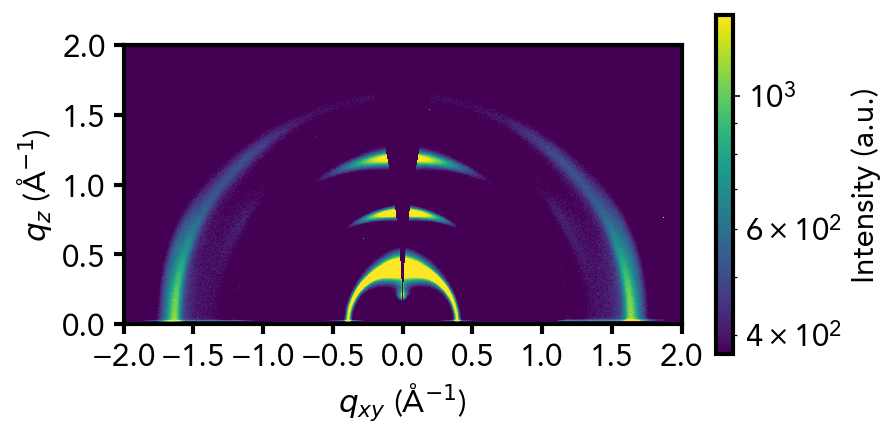

In [5]:
fig, ax = processor.plot_qzqxy(qzqxy, qxy_limits=(-2, 2), qz_limits=(0, 2), cmap='viridis')
plt.show()

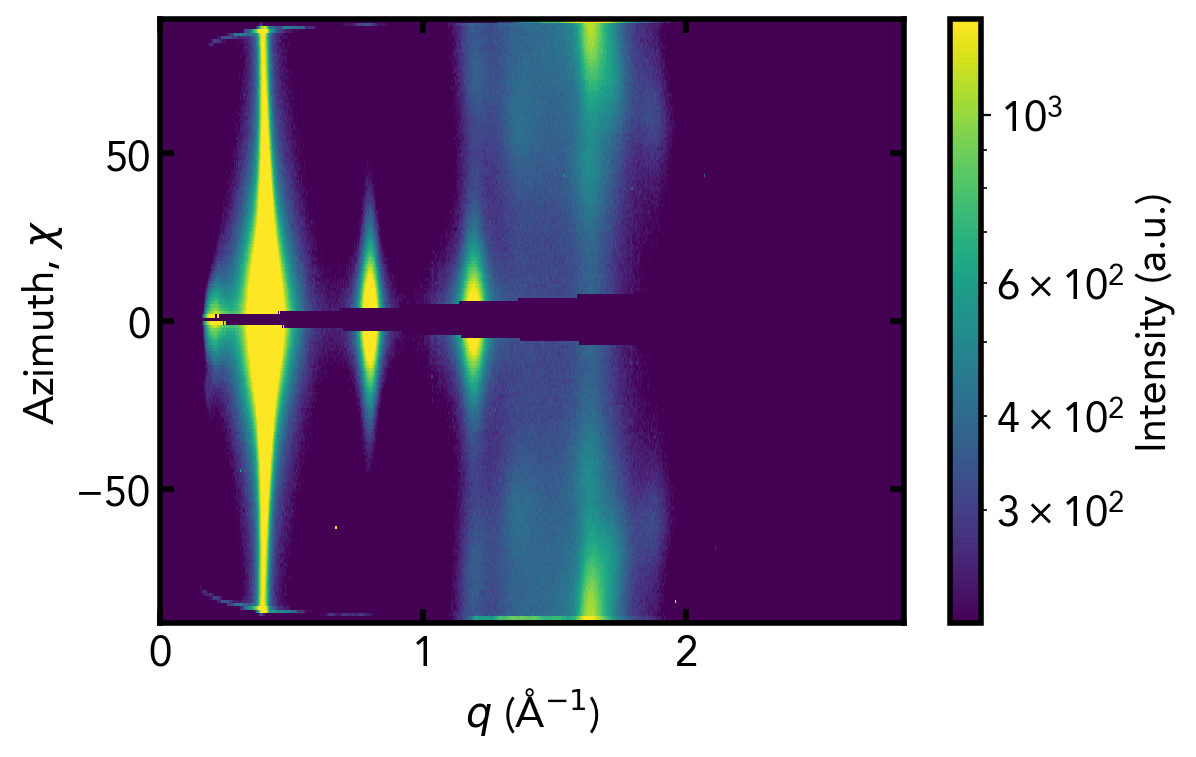

In [6]:
fig, ax = processor.plot_chiq(chiq, cmap='viridis')
plt.show()

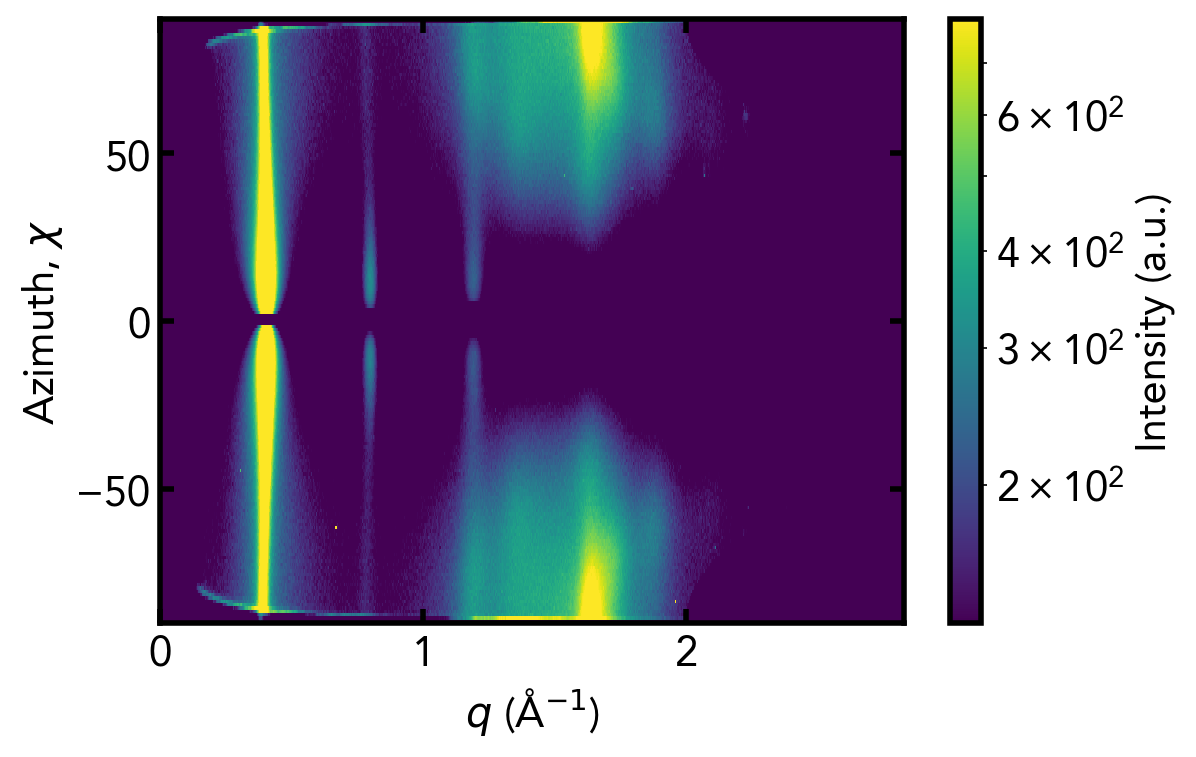

In [7]:
fig, ax = processor.plot_chiq(corrected_chiq, cmap='viridis')
plt.show()

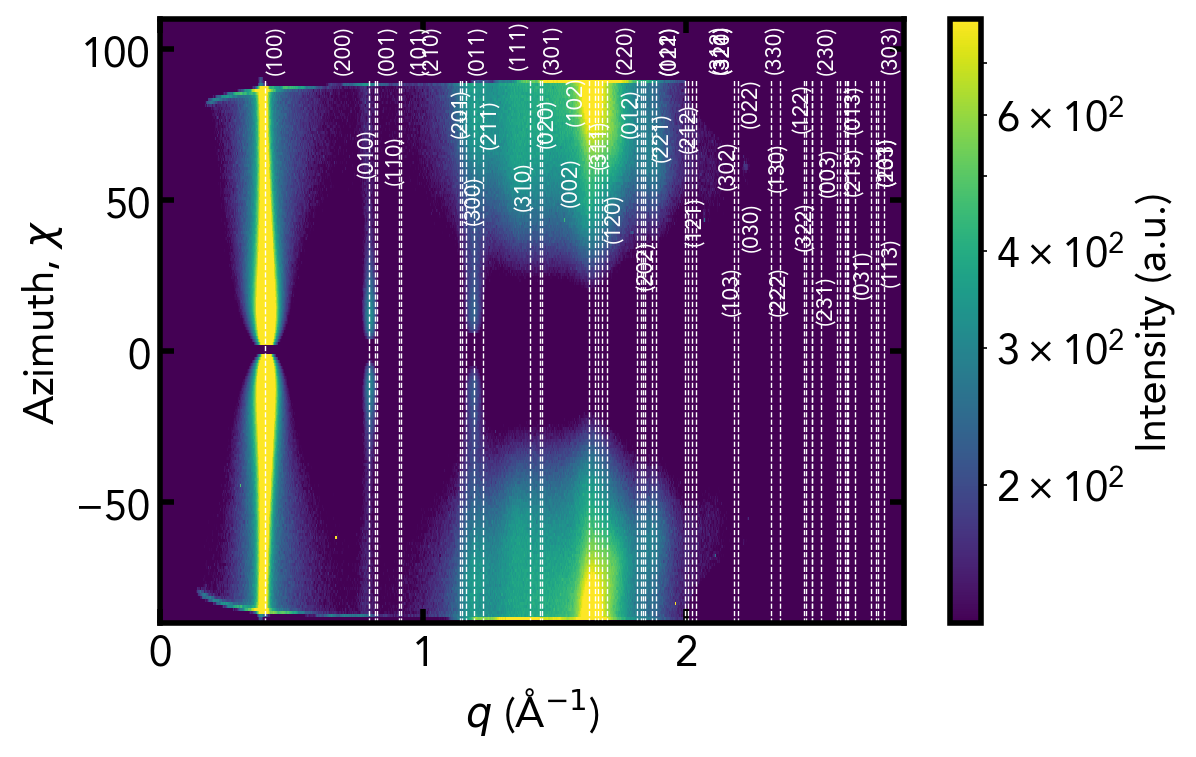

In [8]:
# Set display options for pandas DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Initialize custom Miller indices and other parameters
# custom_miller_indices = [(1, 0, 0), (2, 0, 0), (3, 0, 0), (0, 2, 0), (0, 0, 2), (0, -2, 0), (0, 0, -2)]
custom_miller_indices = []
max_miller_index = 3
space_group = 'monoclinic'
a = 15.8
b = 7.7
c = 7.6
alpha = 90
beta = 90
gamma = 87

# Create an object of CrystalIndexingAnalyzer
analyzer = CrystalIndexingAnalyzer(space_group, a, b, c, alpha, beta, gamma)

# Call the compute_spacing method
spacing_table = analyzer.compute_spacing(custom_miller_indices, max_miller_index)

# Sort the DataFrame by QSpace_AngstromInverse in ascending order
spacing_table = spacing_table.sort_values(by='QSpace_AngstromInverse')
                         
fig, ax = processor.plot_chiq(corrected_chiq, cmap='viridis')

ax.set_ylim([-90, 110])  # change upper y-axis limit

# Get the maximum q value from the chiq DataFrame
max_q = corrected_chiq['q'].max()

texts = []
# Iterate over DataFrame rows
for idx, row in spacing_table.iterrows():
    # Get q value and Miller indices
    q = row['QSpace_AngstromInverse']
    h, k, l = row['h'], row['k'], row['l']
    
    # If q is greater than max_q, break the loop
    if q > max_q:
        break
    
    # Check if all Miller indices are non-negative
    if all(index >= 0 for index in [h, k, l]):
        # Add vertical line at q
        ax.plot([q, q], [-90, 90], color='white', linestyle='--', linewidth=0.5)  # line span from -90 to +90

        # Create label with plus-minus sign before non-zero Miller indices
        miller_indices_label = f'({int(abs(h))}{int(abs(k))}{int(abs(l))})'  # Concatenate the indices without commas

        # Add label with Miller indices
        texts.append(ax.text(q, 93.5, miller_indices_label, rotation=90, fontsize=8, color='white'))  # change color to white

# Adjust the position of text labels
adjust_text(texts, expand_text=(1.05, 1.2), expand_points=(1.05, 1.2), force_text=(0.75, 0.75), force_points=(0.75, 0.75))

# Show the plot
plt.show()

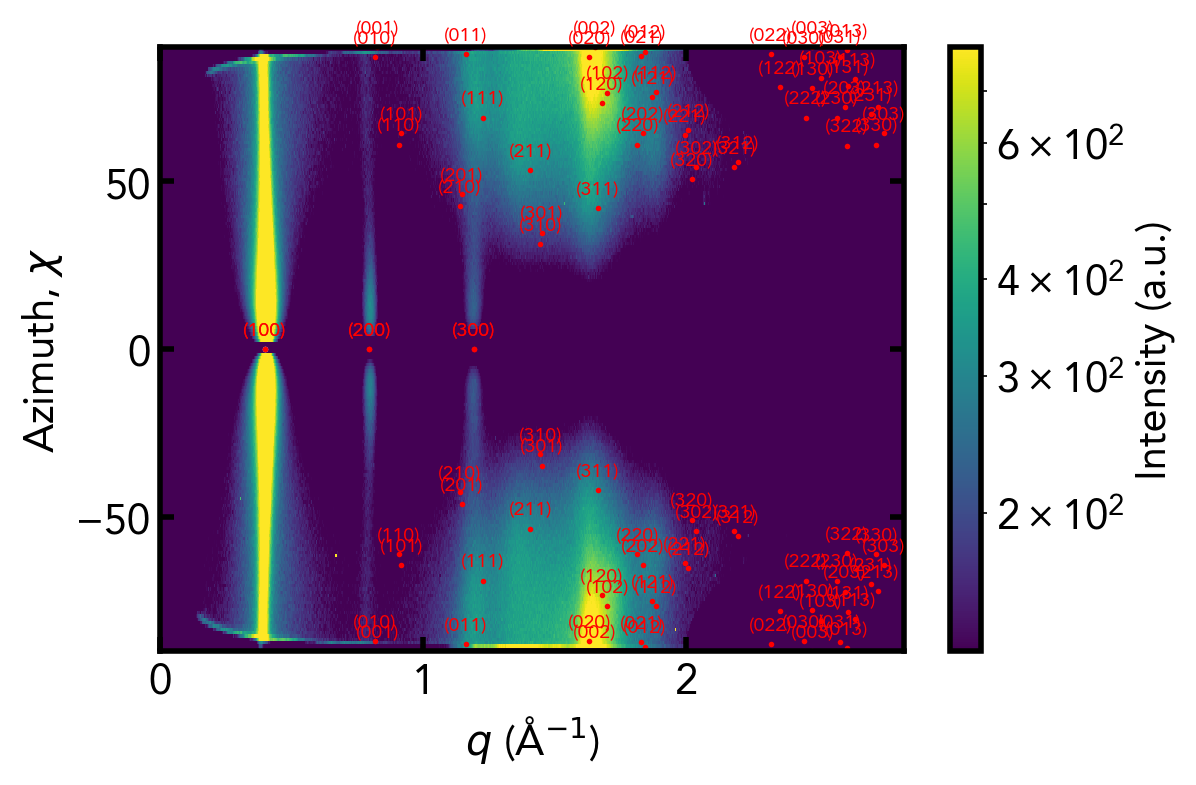

In [9]:
# User specified Miller indices (h1, k1, l1) and approximate chi value
h1, k1, l1 = 1, 0, 0 
approx_chi = 0

# Calculate 'Interplanar Angle' and 'Chi'
spacing_table = analyzer.calculate_interplanar_and_chi(spacing_table, h1, k1, l1, approx_chi = approx_chi)

# Generate the chi-q plot
fig, ax = processor.plot_chiq(corrected_chiq, cmap='viridis')

# Plot a circle at the chi and q of the user-specified Miller index
ref_q = spacing_table.loc[(spacing_table['h'] == h1) & (spacing_table['k'] == k1) & (spacing_table['l'] == l1), 'QSpace_AngstromInverse'].values[0]
ax.plot(ref_q, approx_chi, marker='.', markersize=2, color='white')

# Create a list to collect all the text objects for adjusting
texts = []

# Iterate through the rest of the list and plot the interplanar angles
for idx, row in spacing_table.iterrows():
    q = row['QSpace_AngstromInverse']
    chi = row['Chi']

    # If the current point is the reference point, skip it
    if row['h'] == h1 and row['k'] == k1 and row['l'] == l1:
        text = ax.annotate(f'({abs(int(h1))}{abs(int(k1))}{abs(int(l1))})', (ref_q, approx_chi), textcoords="offset points", xytext=(0,5), ha='center', color='red', fontsize=7)
        texts.append(text)
        continue

    # Plot a small dot for each other Miller index within the range of -90 to 90
    if -90 <= chi <= 90:
        ax.plot(q, chi, marker='.', markersize=2, color='red')
        text = ax.annotate(f'({abs(int(row["h"]))}{abs(int(row["k"]))}{abs(int(row["l"]))})', (q, chi), textcoords="offset points", xytext=(0,5), ha='center', color='red', fontsize=7)
        texts.append(text)

# Adjust the texts to minimize overlaps
# adjust_text(texts)

# Show the plot
plt.show()

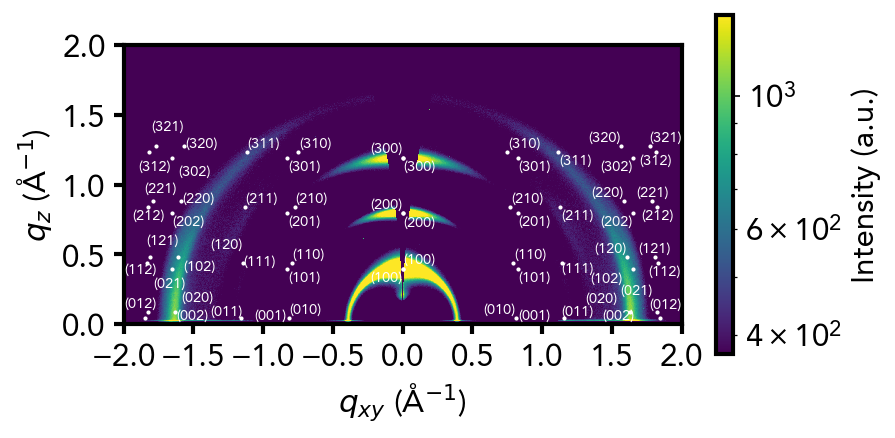

In [10]:
qxy_lower, qxy_upper = -2, 2 
qz_lower, qz_upper = 0, 2  

fig, ax = processor.plot_qzqxy(qzqxy, qxy_limits=(qxy_lower, qxy_upper), qz_limits=(qz_lower, qz_upper), cmap='viridis')

spacing_table = analyzer.compute_q_coordinates(spacing_table)

# Add your texts to a list instead of the plot
texts = []

# Plot a circle at the qxy and qz of the user-specified Miller index
ref_qxy = spacing_table.loc[(spacing_table['h'] == h1) & (spacing_table['k'] == k1) & (spacing_table['l'] == l1), 'qxy'].values[0]
ref_qz = spacing_table.loc[(spacing_table['h'] == h1) & (spacing_table['k'] == k1) & (spacing_table['l'] == l1), 'qz'].values[0]
ax.plot(ref_qxy, ref_qz, marker='.', markersize=2, color='white')
texts.append(ax.text(ref_qxy, ref_qz, f'({int(h1)}{int(k1)}{int(l1)})', ha='center', va='center', fontsize=7, color='white'))

for idx, row in spacing_table.iterrows():
    qxy = row['qxy']
    qz = row['qz']

    # Only plot points and labels if they're within the user-specified axis limits
    if qxy >= qxy_lower and qxy <= qxy_upper and qz >= qz_lower and qz <= qz_upper:
        # Skip the reference point
        if row['h'] == h1 and row['k'] == k1 and row['l'] == l1:
            continue
        ax.plot(qxy, qz, marker='.', markersize=2, color='white')
        texts.append(ax.text(qxy, qz, f'({abs(int(row["h"]))}{abs(int(row["k"]))}{abs(int(row["l"]))})', ha='center', va='center', fontsize=7, color='white'))

# Use adjust_text, which will take care of text overlapping
# adjust_text will stop after 500 iterations (default) or when no overlap will be detected
adjust_text(texts)

# Show the plot
plt.show()

In [ ]:
# Initialize lists to store the data
sample_names = []
incidence_angles = []
exposure_times = []
filenames = []
qzqxys = []
chiqs = []
corrected_chiqs = []

# Search for all '_qzqxy.tif' files in the directory tree
all_files = glob.glob('**/*_qzqxy.tif', recursive=True)

# Loop through each found file
for file_path in tqdm(all_files, desc="Processing files"):
    # Extract metadata from the filename
    file = os.path.basename(file_path)

    # Use regular expression to parse the filename
    match = re.search(r'(.+)_(\d+p\d+)deg_(\d+)s', file)
    sample_name = match.group(1)
    incidence_angle = float(match.group(2).replace('p', '.'))  # Convert '0p13' to 0.13
    exposure_time = int(match.group(3))  # Convert '120s' to 120

    processor = GIWAXSDataProcessor(q_max=2.0)
    
    qzqxy, chiq, corrected_chiq = processor.process_giwaxs_file(file_path)

    # Update the attributes of each xarray DataArray
    for xr in [qzqxy, chiq, corrected_chiq]:
        xr.attrs.update({
            'sample_name': sample_name,
            'incidence_angle': incidence_angle,
            'exposure_time': exposure_time})

    # Append to lists
    sample_names.append(sample_name)
    incidence_angles.append(incidence_angle)
    exposure_times.append(exposure_time)
    filenames.append(file)
    qzqxys.append(qzqxy)
    chiqs.append(chiq)
    corrected_chiqs.append(corrected_chiq)

    # Define the name for the pickle file
    pickle_save_name = 'processed_giwaxs.pkl'

    # Save variables to pickle
    with open(pickle_save_name, 'wb') as file:
        pickle.dump([sample_names, incidence_angles, exposure_times, filenames, qzqxys, chiqs, corrected_chiqs], file, protocol=-1)

Processing files:  83%|█████████████████████████████████████████████████████▎          | 40/48 [20:14<10:51, 81.42s/it]

In [11]:
# Initialize list to store background-subtracted data
background_subtracted_qzqxys = []
background_subtracted_chiqs = []
background_subtracted_corrected_chiqs = []

# Define a common set of 'qxy', 'qz', q', 'chi' coordinates
qxy_common = np.linspace(-2, 2, num=1000)
qz_common = np.linspace(0, 2, num=1000)
q_common = np.linspace(0, 2, num=1000)
chi_common = np.linspace(-180, 180, num=1000)

# Loop through each sample
for i, sample_name in enumerate(sample_names):
#     # Skip if the sample is a blank
#     if sample_name == 'SiO2_200nm_on_Si':
#         continue

    incidence_angle_sample = incidence_angles[i]

    # Find the index of the corresponding blank
    blank_idx = None
    for j, (blank_name, incidence_angle_blank) in enumerate(zip(sample_names, incidence_angles)):
        if blank_name == 'SiO2_200nm_on_Si' and incidence_angle_sample == incidence_angle_blank:
            blank_idx = j
            break

    if blank_idx is None:
        print(f"Could not find a corresponding blank for sample {sample_name} at incidence angle {incidence_angle_sample}")
        continue

    # Background subtraction for qzqxy
    qzqxy_sample = qzqxys[i].interp(qxy=qxy_common, qz=qz_common)
    qzqxy_blank = qzqxys[blank_idx].interp(qxy=qxy_common, qz=qz_common)
    qzqxy_diff = qzqxy_sample - qzqxy_blank

    # Background subtraction for chiq
    chiq_sample = chiqs[i].interp(q=q_common, chi=chi_common)
    chiq_blank = chiqs[blank_idx].interp(q=q_common, chi=chi_common)
    chiq_diff = chiq_sample - chiq_blank

    # Background subtraction for corrected_chiq
    corrected_chiq_sample = corrected_chiqs[i].interp(q=q_common, chi=chi_common)
    corrected_chiq_blank = corrected_chiqs[blank_idx].interp(q=q_common, chi=chi_common)
    corrected_chiq_diff = corrected_chiq_sample - corrected_chiq_blank

    # Append background-subtracted data to new lists
    background_subtracted_qzqxys.append(qzqxy_diff)
    background_subtracted_chiqs.append(chiq_diff)
    background_subtracted_corrected_chiqs.append(corrected_chiq_diff)

NameError: name 'sample_names' is not defined

In [ ]:
fig, ax = processor.plot_qzqxy(background_subtracted_qzqxys[3], qxy_limits=(-2, 2), qz_limits=(0, 2), cmap='viridis')
fig, ax = processor.plot_qzqxy(qzqxys[3], qxy_limits=(-2, 2), qz_limits=(0, 2), cmap='viridis')

In [ ]:
fig, ax = processor.plot_qzqxy_sq(background_subtracted_qzqxys[5])

# Add dashed circles to represent fixed q values
circle_lower = Circle((0, 0), q_lower, color='white', fill=False, linestyle='dashed', linewidth=0.5)
circle_upper = Circle((0, 0), q_upper, color='white', fill=False, linestyle='dashed', linewidth=0.5)

ax.add_artist(circle_lower)
ax.add_artist(circle_upper)

# Show the plot
plt.show()

In [ ]:
with open('processed_giwaxs.pkl', 'rb') as file:
    data = pickle.load(file)

dicts = {'sample_names': sample_names, 'incidence_angles': incidence_angles, 'exposure_times': exposure_times, 'filenames': filenames, 'qzqxys': qzqxys, 'chiqs': chiqs, 'corrected_chiqs': corrected_chiqs, 'orientation_dists': orientation_dists}

In [ ]:
def filter_data(data, current_samples, current_incidence_angle, key):
    ## filter the larger pool of data to contain only data pertaining to the selected edge:
    # create boolean list to filter larger pool of data
    samples = data[0]
    incidence_angles = data[1]

    filter_list = []
    del filter_list
    filter_list = []

    for i, (sample, incidence_angle) in enumerate(zip(samples, incidence_angles)):
        if (sample in current_samples) and (incidence_angle == current_incidence_angle):
            filter_list.append(True)
        else:
            filter_list.append(False)

    # use boolean list to filter data
    filtered_data = []
    del filtered_data
    filtered_data = []

    for i, list_item in enumerate(data):
        filtered_list = []
        del filtered_list
        filtered_list = []
        for j, item in enumerate(data[i]):
            if filter_list[j]:
                filtered_list.append(item)
        filtered_data.append(filtered_list)
        
    # create dict of lists for ease with selecting data to make into mosaic
    data_dict = {'sample_names':filtered_data[0], 
                 'incidence_angles': filtered_data[1], 
                 'exposure_times': filtered_data[2], 
                 'filenames': filtered_data[3], 
                 'qzqxys': filtered_data[4], 
                 'chiqs': filtered_data[5], 
                 'corrected_chiqs': filtered_data[6], 
                 'orientation_dists': filtered_data[7]}

    dicts = dict(zip(data_dict['sample_names'], data_dict[key]))

    scales = []
    for key in data_dict['sample_names']:
        scales.append(np.nanmax([abs(np.nanpercentile(dicts[key],1)), abs(np.nanpercentile(dicts[key],99))]))
    
    return dicts, scales

In [ ]:
def generate_ticks(start, end, num_ticks, rounding_order):
    tick_spacing = (end - start) / (num_ticks - 1)
    tick_vals = [start + i * tick_spacing for i in range(num_ticks)]
    rounded_tick_vals = [round(val / rounding_order) * rounding_order for val in tick_vals]
    
    return rounded_tick_vals

def plot_qzqxy_grid(dicts, scales, current_samples, start_q, end_q, q_rounding_order):
    fig, axes = plt.subplots(3, 6, figsize=(3.5*6, 3.5*3))
    
    x_ticks = generate_ticks(start_q, end_q, num_ticks = 5, rounding_order = q_rounding_order)
    y_ticks = generate_ticks(start_q, end_q, num_ticks = 5, rounding_order = q_rounding_order)

    for j in range(3):
        for i in range(5):
            key = current_samples[i*3+j]
            ax = axes[j, i]

            if key in dicts:
                qzqxy = dicts[key].sel(qxy=slice(start_q, end_q),qz=slice(start_q, end_q))
                
                # Mirror and sum the data
                mirrored_qzqxy = qzqxy.sel(qxy=slice(None, 0))
                mirrored_qzqxy['qxy'] = -mirrored_qzqxy['qxy']
                truncated_qzqxy = qzqxy.sel(qxy=slice(0, 2))
                combined_qzqxy = truncated_qzqxy + mirrored_qzqxy.reindex_like(truncated_qzqxy, method='nearest', tolerance=1e-5).fillna(0)
                
                # Plot
                im = combined_qzqxy.plot(x='qxy', y='qz', ax=ax,vmin=-np.nanmax(scales), vmax=np.nanmax(scales),
                                         cmap='viridis', add_colorbar=False)
            else:
                ax.text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center', fontsize=18)

            ax.text(0.035, 0.875, key, color='black', fontsize=18,
                    transform=ax.transAxes, horizontalalignment='left',
                    bbox=dict(facecolor='white', edgecolor='white', alpha=0.75))

            ax.set_xticklabels('')
            ax.set_yticklabels('')
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_xticks(x_ticks)
            ax.set_yticks(y_ticks)
            ax.set_xlim([start_q, end_q])
            ax.set_ylim([start_q, end_q])
            ax.xaxis.set_tick_params(which='both', size=5, width=2, direction='inout', top='on')
            ax.yaxis.set_tick_params(which='both', size=5, width=2, direction='inout', right='on')
    
   # format title and labels
    top_labels = ['0/0/100\n(5 kDa/23 kDa/RRa)', '20/5/75\n(5 kDa/23 kDa/RRa)',
                  '40/5/55\n(5 kDa/23 kDa/RRa)', '50/5/45\n(5 kDa/23 kDa/RRa)',
                  '70/0/30\n(5 kDa/23 kDa/RRa)', '100/0/0\n(5 kDa/23 kDa/RRa)']
    for i, label in enumerate(top_labels):
        ax = axes[0, i]
        ax.text(0.5, 1.2, label, color='black', fontsize=20, transform=ax.transAxes,
                horizontalalignment='center', verticalalignment='center')
        ax = axes[-1, i]
        ax.set_xlabel('$\it{q_{xy}}$ (Å$^{-1}$)', fontsize=20)
        x_ticks_strs = [str(value) for value in x_ticks]
        x_ticks_strs[0] = ''
        x_ticks_strs[-1] = ''
        ax.set_xticklabels(x_ticks_strs)

    for i, label in enumerate(['Undoped', 'F$_{4}$TCNQ$^{•-}$ \n vapor', 'TFSI$^{-}$ anion \n exhanged']):
        ax = axes[i, 0]
        ax.set_ylabel('$\it{q_{z}}$ (Å$^{-1}$', fontsize=20)
        y_ticks_strs = [str(value) for value in y_ticks]
        y_ticks_strs[0] = ''
        y_ticks_strs[-1] = ''
        ax.set_yticklabels(y_ticks_strs)
        ax.text(-1, 0.5, label, color='black', fontsize=20, transform=ax.transAxes,
                horizontalalignment='left', verticalalignment='center')

    plt.tight_layout()

#     # format colorbar
#     cbar_ax = fig.add_axes([1, 0.11, 0.01, 0.725])
#     cbar = fig.colorbar(im, cax=cbar_ax, format=FuncFormatter(fmt_AR))
#     cbar.ax.set_ylabel('Intensity')
    plt.show()

    return fig, axes

In [ ]:
current_incidence_angle = 0.05

current_samples = ['EPAN', 'EPAV', 'EPAA', 'EPBN', 'EPBV', 'EPBA', 'EPCN', 'EPCV', 'EPCA', 'EPDN', 'EPDV', 'EPDA', 'EPEN', 'EPEV', 'EPEA']

dicts, scales = filter_data(data, current_samples, current_incidence_angle, 'qzqxys')

scales = [0.35]

[fig, axes] = plot_qzqxy_grid(dicts, scales, current_samples, 0.2, 2, 0.5)

In [ ]:
len(current_samples)